# Identifying Credit Card Fraud with Deep Learning

**Final Project for Introduction to Deep Learning**

### Table of Contents

- [1 Introduction](#introduction)
  - [1.1 Subject Background](#subject-background)
  - [1.2 Dataset](#dataset)
  - [1.3 Model Evaluation](#model-evaluation)
  - [1.4 Library Import](#library-import)
- [2 EDA/Data Preparation](#data-preparation)
  - [2.1 Data Import](#data-import)
  - [2.2 Data Exploration](#data-exploration)
  - [2.3 Confusion Matrix Function](#confusion-matrix-function)
  - [2.4 Data-Split](#data-split)
- [3 Modeling](#modeling)
  - [3.1 Setting Optimizer & Loss Function](#Setting-Optimizer)
  - [3.2 Applying Random Forest Classifier](#applying-random-forest-classifier)
  - [3.3 Applying Decision Tree Classifier](#applying-decision-tree-classifier)
  - [3.4 Applying Undersampling](#applying-undersampling)
  - [3.5 Applying SMOTE for Oversampling](#applying-SMOTE-for-oversampling)
- [4 Conclusion](#conclusion)


<img src="https://images.pexels.com/photos/5849559/pexels-photo-5849559.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1" alt="drawing" />

## 1 Introduction <a name="introduction"></a>

### 1.1 Subject Background  <a name="subject-background"></a>

Fraudulent activities related to credit cards have grown in complexity, thanks to the utilization of advanced technologies by criminals. Identifying anomalous transactions has become a challenging task, especially without prior reports from customers. Consequently, the incorporation of machine learning algorithms becomes essential when handling financial or sensitive customer data. These algorithms possess the capability to analyze large volumes of diverse data types, such as texts, images, and videos. By discerning patterns swiftly and accurately, they play a crucial role in detecting anomalies within seconds. Anomaly detection involves recognizing data points, items, observations, or events that deviate from the anticipated pattern within a specified group. While these anomalies are rare occurrences, they can signify substantial and noteworthy threats, such as cyber intrusions or fraud. The application of anomaly detection is prevalent in behavioral analysis and various analytical methodologies, facilitating the learning process related to detecting, identifying, and predicting the occurrence of these irregularities.

### 1.2 Dataset <a name="dataset"></a>

In the dataset, there are transactions executed using credit cards in the September of 2013, specifically by cardholders in Europe. Over a period of two days, there were only 492 instances of fraud out of a total of 284,807 transactions, resulting in a dataset that is markedly imbalanced. The positive class, which signifies fraudulent activities, represents a mere 0.172% of the entire transaction volume.  This will make it difficult 

The dataset exclusively consists of numerical input variables derived from a PCA transformation. Unfortunately, owing to confidentiality constraints, the original features and additional background information regarding the data remain undisclosed. Principal components V1 through V28 are the products of the PCA, while 'Time' and 'Amount' remain unaltered by this transformation. 'Time' signifies the seconds elapsed between each transaction and the initial transaction in the dataset, while 'Amount' denotes the transaction amount—a feature that finds utility, for instance, in example-dependent cost-sensitive learning. The 'Class' feature serves as the response variable, taking on a value of 1 in cases of fraud and 0 otherwise.

### 1.3 Model Evaluation <a name="model-evaluation"></a>

Due to the highly skewed nature of the data, with only 0.17% of transactions being fraudulent out of 280,000 samples, relying on accuracy is not a reliable metric. A model predicting all transactions as normal would achieve a misleadingly high accuracy of 99.83%.

In addressing this imbalance, it's essential to focus on reducing the false negatives as much as possible, essentially Recall, though we are not overly worried about false positives in this particular case.

### 1.4 Library Import <a name="library-import"></a>


In [58]:
import pandas as pd
import numpy as np
from numpy import ma
import scipy
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math
import matplotlib
import matplotlib.colors as colors
from matplotlib import ticker, cm
from matplotlib.pyplot import figure
import seaborn as sns
%matplotlib inline
from imblearn.over_sampling import SMOTE
import itertools
import keras
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Dense
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from scipy.stats.mstats import winsorize
from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score, confusion_matrix, classification_report, precision_recall_fscore_support,accuracy_score
from sklearn.covariance import EllipticEnvelope
import os

import warnings
warnings.filterwarnings("ignore")

np.random.seed(2)

## 2 Data Preparation <a name="data-preparation"></a>

### 2.1 Data Import <a name="data-import"></a>

In [59]:
dfRaw = pd.read_csv("data/creditcard.csv")
df = dfRaw.copy()
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### 2.2 Data Exploration <a name="data-exploration"></a>

In exploring the data, we will see that the data is very clean to begin with.  There are no nulls or missing values in any columns.  There is also plenty of data to explore.  We wil see as we examine the data further that there is significant overlap in the features between fraud and normal transactions. This is one element that makes it so difficult to identify fraud transactions.  We will also see the two separate sections of transactions.  This is reflective of the two-day window of time over which the transactions occured.

In [60]:
df[df.columns].isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

data:  (284807, 31)
normal_data:  (284315, 31)
fraud_data:  (492, 31)
Percent fraud:  0.17305 %
____________________________________________________________________________________________________


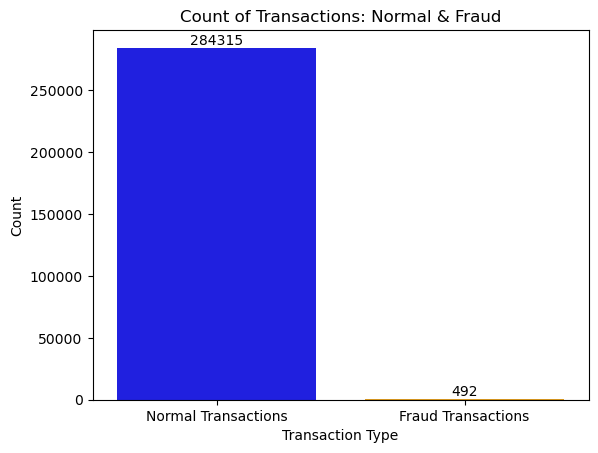

In [61]:
data = df.copy()
normal_data = data.loc[data["Class"] == 0]
fraud_data = data.loc[data["Class"] == 1]

print("data: ", data.shape)
print("normal_data: ", normal_data.shape)
print("fraud_data: ", fraud_data.shape)
print("Percent fraud: ", round(100 * fraud_data.shape[0] / normal_data.shape[0], 5), "%")
print("_" * 100)

values = [normal_data.shape[0], fraud_data.shape[0]]
colors = ['blue', 'orange']

ax = sns.barplot(x=['Normal Transactions', 'Fraud Transactions'], y=values, palette=colors)

plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.title('Count of Transactions: Normal & Fraud')

for i, v in enumerate(values):
    ax.text(i, v + 50, str(v), ha='center', va='bottom')

plt.show()

In [62]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

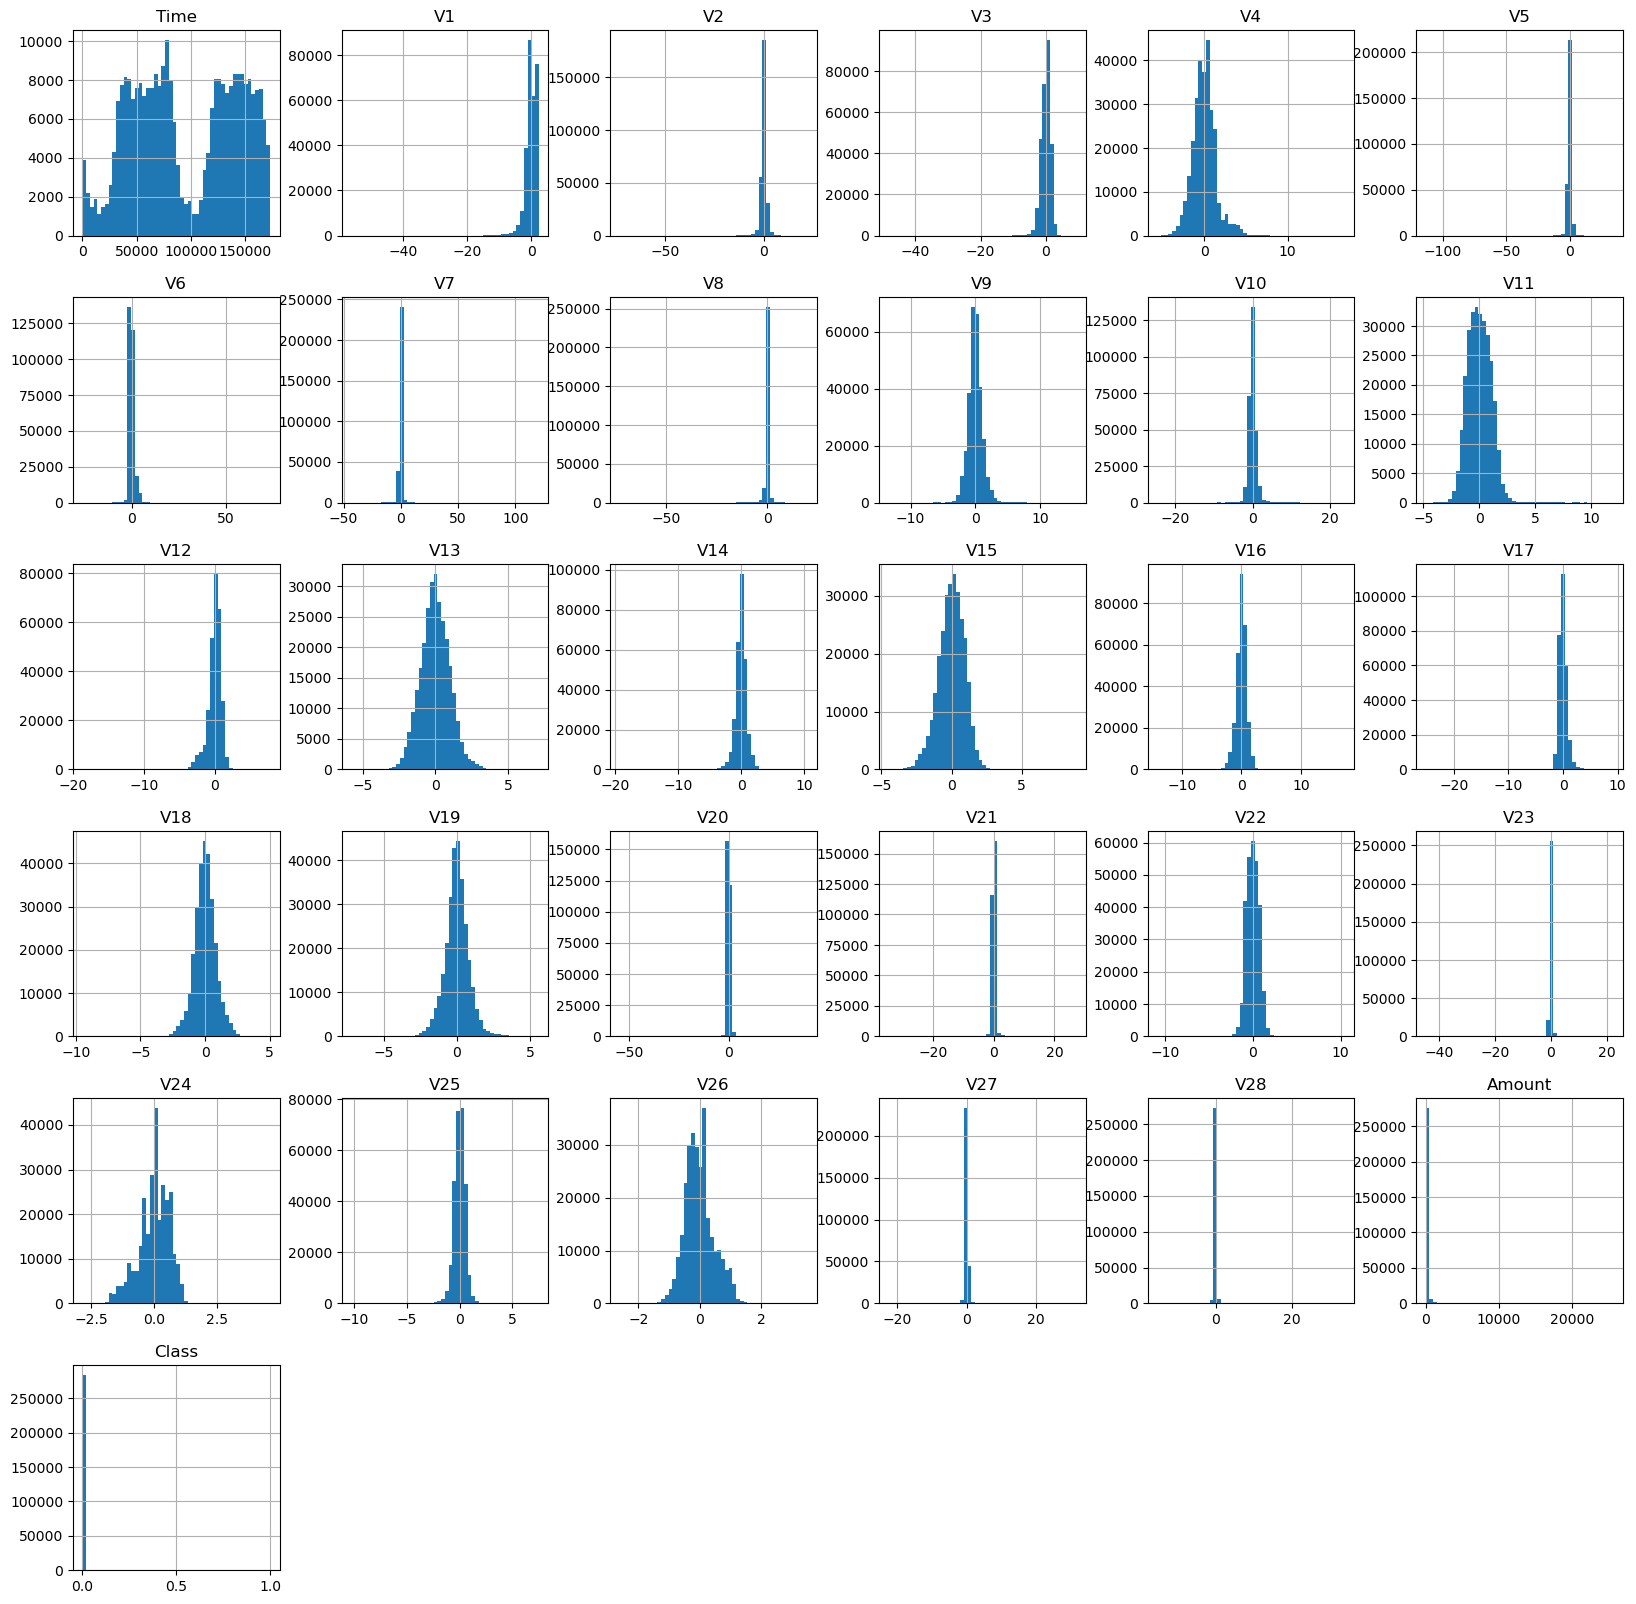

In [63]:
df.hist(bins = 50, figsize = (20,20))
plt.show()

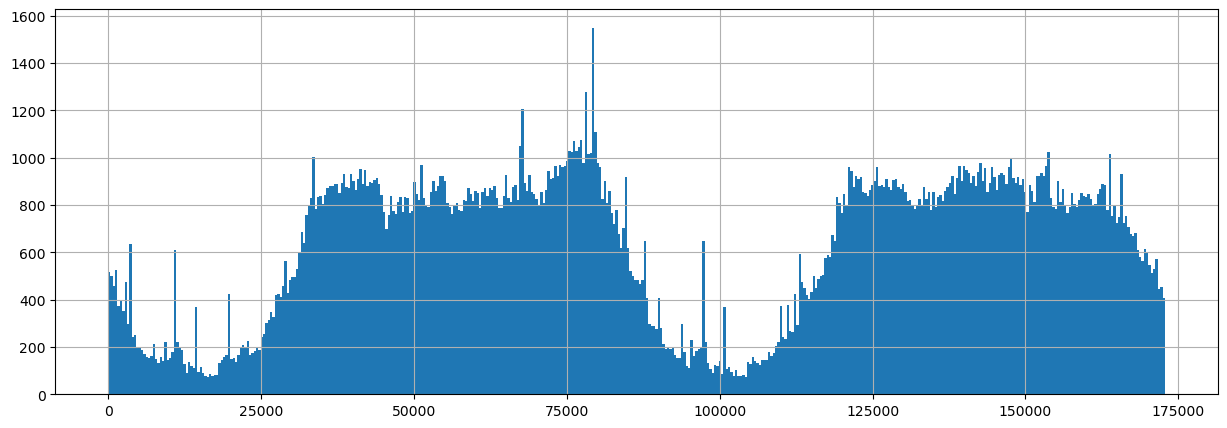

In [64]:
df['Time'].hist(bins = 450, figsize = (15,5))
plt.show()

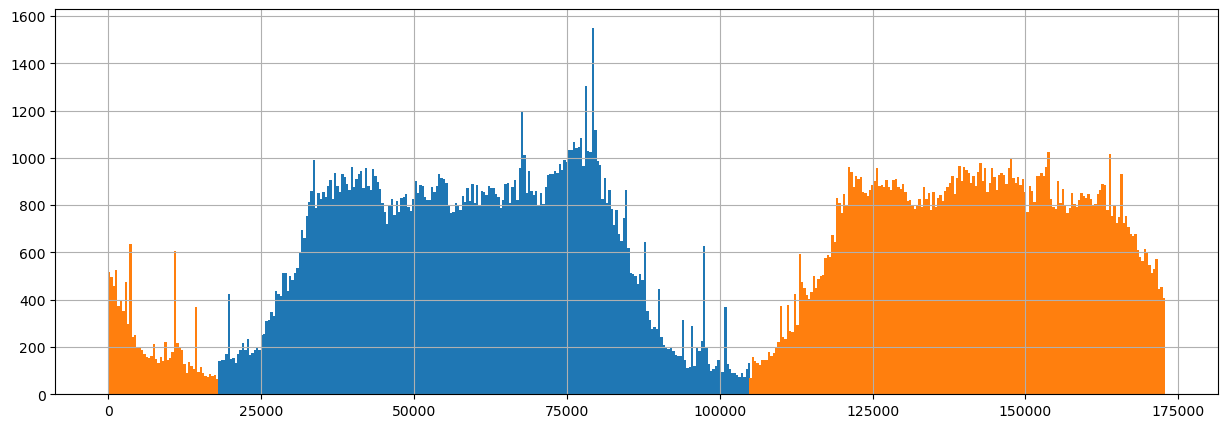

In [65]:
Data = df.loc[(df['Time']>18001) & (df['Time']<105000),:]
Data_test = df.loc[(df['Time']<18000) | (df['Time']>105001),:] 

Data['Time'].hist(bins = 225, figsize = (15,5))
Data_test['Time'].hist(bins = 450, figsize = (15,5))
plt.show()

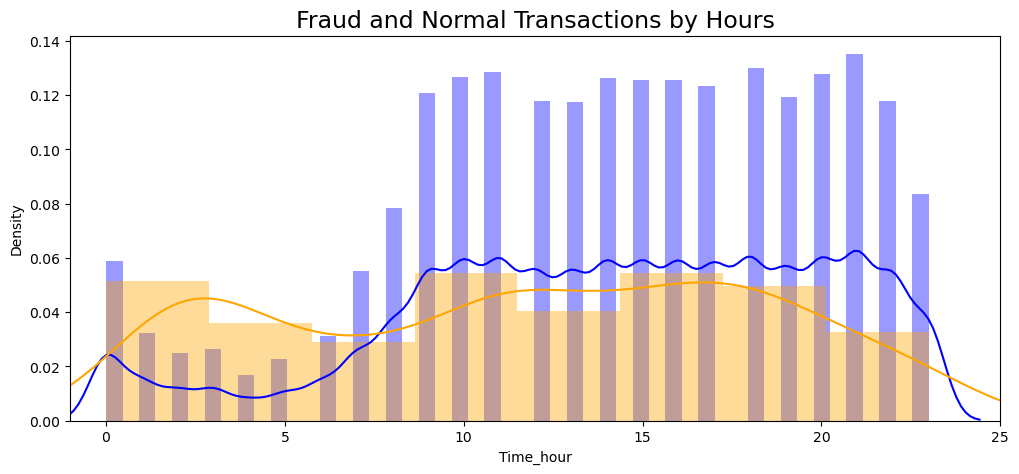

In [66]:
timedelta = pd.to_timedelta(df['Time'], unit='s')
df['Time_hour'] = (timedelta.dt.components.hours).astype(int)

plt.figure(figsize=(12,5))
sns.distplot(df[df['Class'] == 0]["Time_hour"], color='blue')
sns.distplot(df[df['Class'] == 1]["Time_hour"], color='orange')
plt.title('Fraud and Normal Transactions by Hours', fontsize=17)
plt.xlim([-1,25])
plt.show()

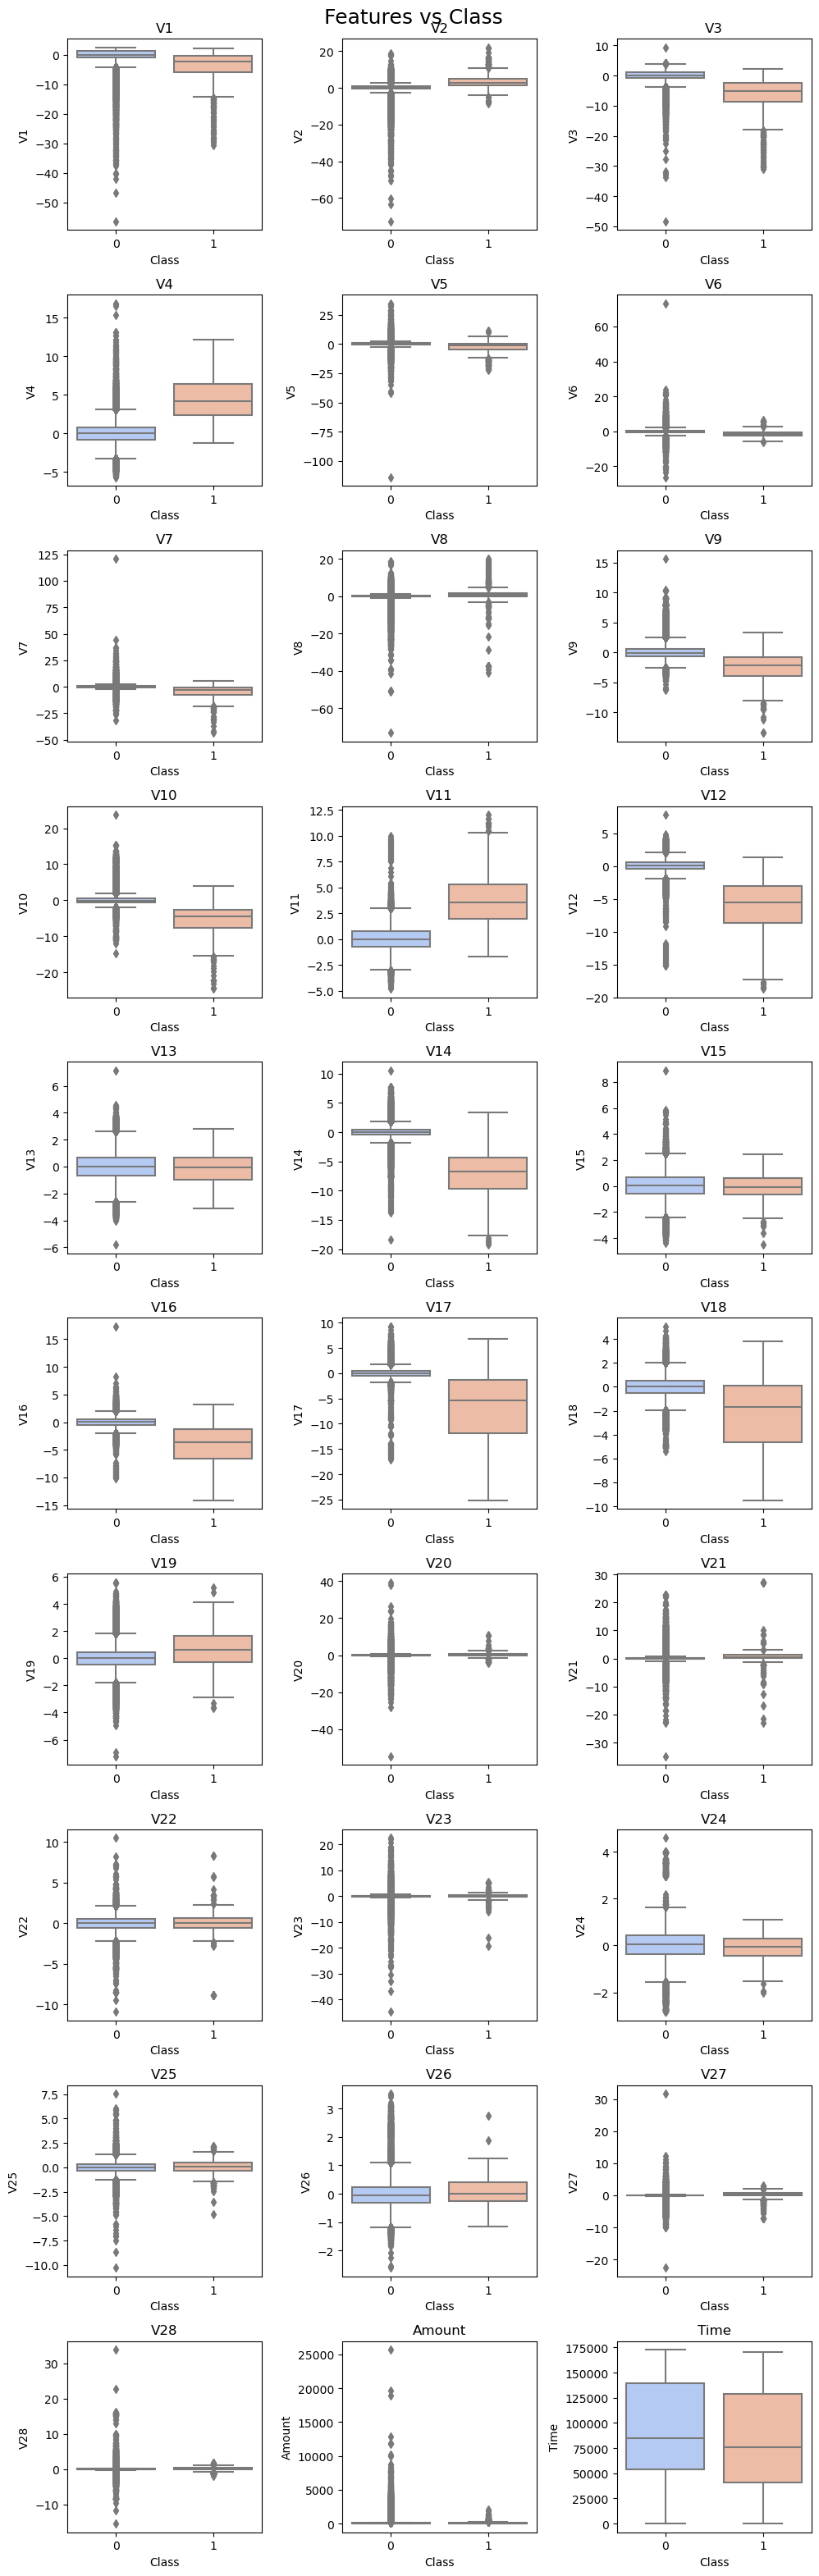

In [67]:
fig, axes = plt.subplots(nrows=10, ncols=3,figsize=(10,32))
fig.suptitle('Features vs Class\n', size = 18)

count = 1

for i in range(10):
    for j in range(3):
        if count <= 28:
            sns.boxplot(ax=axes[i, j], data=df, x='Class', y=f"V{count}", palette='coolwarm')
            axes[i,j].set_title(f"V{count}");
        elif count == 29:
            sns.boxplot(ax=axes[i, j], data=df, x='Class', y=f"Amount", palette='coolwarm')
            axes[i,j].set_title(f"Amount");
        else:
            sns.boxplot(ax=axes[i, j], data=df, x='Class', y=f"Time", palette='coolwarm')
            axes[i,j].set_title(f"Time");
        
        count += 1
        
plt.tight_layout()

In [68]:
data['normalized_amount']=StandardScaler().fit_transform(data['Amount'].values.reshape(-1,1))

data=data.drop(['Amount'],axis=1)
data=data.drop(['Time'],axis=1)

cols= df[['Time', 'Amount']]

pca = PCA()
pca.fit(cols)
X_PCA = pca.transform(cols)

dfCopy = df.copy()

dfCopy.drop(['Time','Time_hour','Amount'], axis=1, inplace=True)


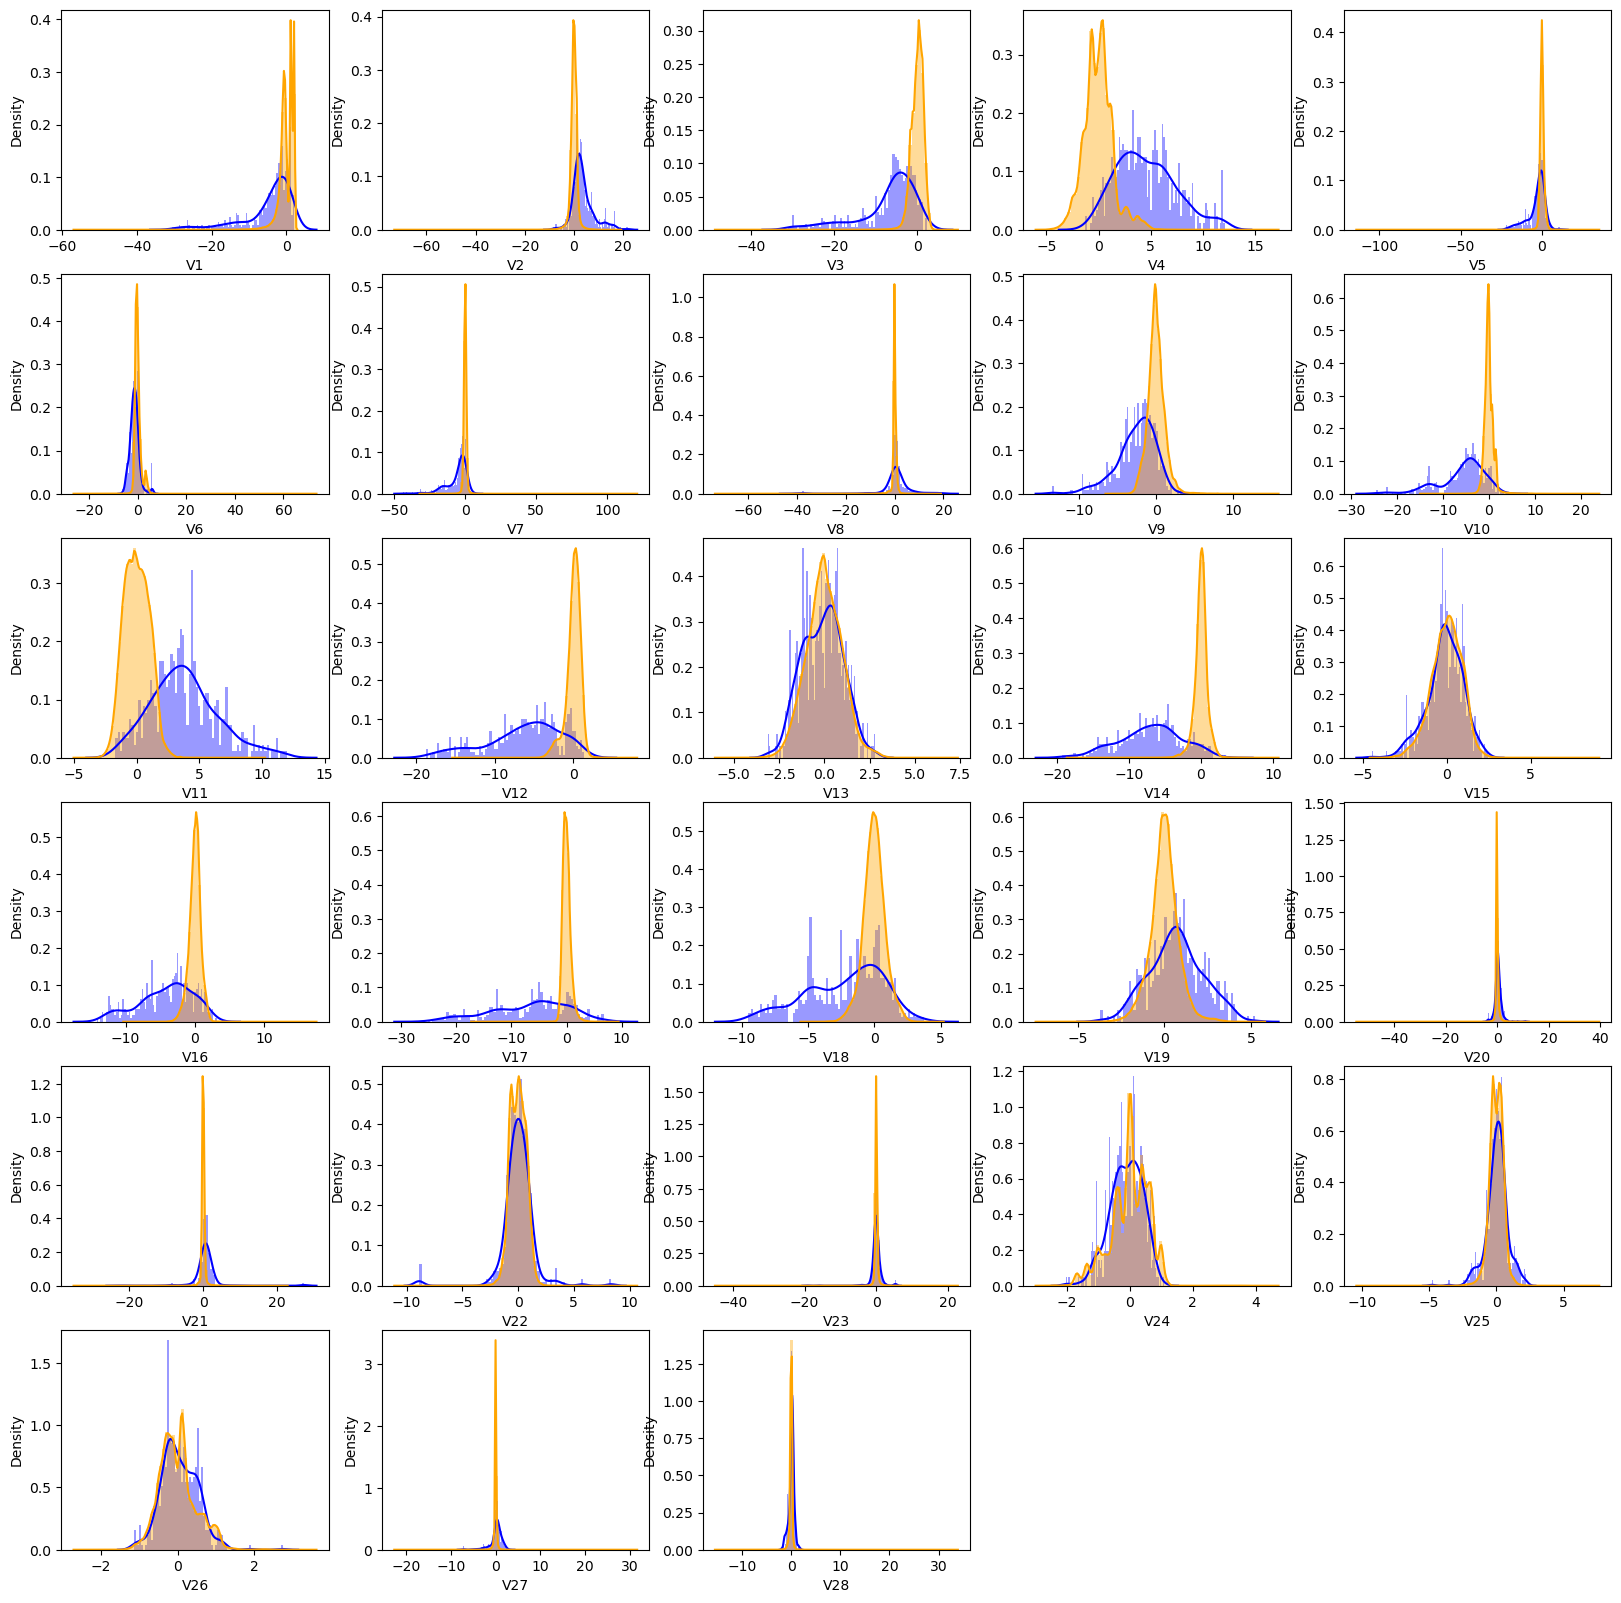

In [69]:
columns = dfCopy.drop('Class', axis=1).columns
grid = gridspec.GridSpec(6, 5)

plt.figure(figsize=(20, 10*2))

for n, col in enumerate(dfCopy[columns]):
    ax = plt.subplot(grid[n])
    sns.distplot(dfCopy[dfCopy.Class == 1][col], bins=75, color='blue')
    sns.distplot(dfCopy[dfCopy.Class == 0][col], bins=75, color='orange') 
    ax.set_ylabel('Density')

plt.show()
df.drop(['Time','Amount'], axis=1, inplace=True)

### 2.3 Confusion Matrix Function <a name="confusion-matrix-function"></a>

The following function is going to be helpful in easily creating and formatting confusion matrices that display the results of our models.

In [70]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', is_normalized=False, color_map=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    The `is_normalized` parameter allows for normalization if set to True.
    """
    if is_normalized:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
        print('Confusion Matrix (Unnormalized)')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=color_map)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    format_str = '.2f' if is_normalized else 'd'
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], format_str),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > threshold else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()

### 2.4 Data Split <a name="data-split"></a>

In [71]:
X=data.iloc[:,data.columns!='Class']
y=data.iloc[:,data.columns=='Class']

In [72]:
X.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,normalized_amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403


In [73]:
y.head()

,Class
0,0
1,0
2,0
3,0
4,0


In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

In [75]:
X_train = np.array(X_train)
X_test=np.array(X_test)
y_train=np.array(y_train)
y_test=np.array(y_test)

The following code defines a neural network model for binary classification using Keras Sequential API. It consists of several layers, each introducing non-linearity to the model's computations. The network architecture progressively adds complexity through interconnected layers, aiming to capture intricate patterns in the input data. Dropout regularization is applied to prevent overfitting, and the final layer outputs probabilities for binary classification tasks. The model summary provides an overview of the architecture's design and the number of parameters involved, essential for assessing its complexity and potential performance.

In [76]:
model = Sequential([
     Dense(units=16, input_dim=29, activation='relu'),
     Dense(units=24,activation='relu'),
     Dropout(0.5),
     Dense(20,activation='relu'),
     Dense(24,activation='relu'),
     Dense(1,activation='sigmoid')  
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 16)                480       
                                                                 
 dense_11 (Dense)            (None, 24)                408       
                                                                 
 dropout_2 (Dropout)         (None, 24)                0         
                                                                 
 dense_12 (Dense)            (None, 20)                500       
                                                                 
 dense_13 (Dense)            (None, 24)                504       
                                                                 
 dense_14 (Dense)            (None, 1)                 25        
                                                                 
Total params: 1,917
Trainable params: 1,917
Non-traina

# Modeling

### 3.1 Setting Optimizer & Loss Function <a name='Setting-Optimizer'> <a/>

Upon completing the layer integration within our model, the subsequent step involves configuring crucial components: a scoring function, a loss function, and an optimization algorithm. The loss function is pivotal as it quantifies the model's performance concerning known labels, essentially measuring the discrepancy between observed and predicted labels. Specifically tailored for categorical classifications, especially in binary scenarios, we've opted for the "binary_crossentropy" loss function, which effectively captures the error rate between observed and predicted labels.

A crucial aspect lies within the optimization algorithm, tasked with iteratively refining parameters such as filter kernel values, weights, and neuron biases to minimize the loss. Our selection, the Adam optimizer, amalgamates the strengths found in two other stochastic gradient descent variants. Firstly, the Adaptive Gradient Algorithm (AdaGrad) maintains per-parameter learning rates, proving beneficial in scenarios with sparse gradients, such as those inherent in natural language and computer vision tasks. Secondly, Root Mean Square Propagation (RMSProp) adjusts per-parameter learning rates based on recent gradient magnitudes, making it adept at handling online and non-stationary problems, including those with noise. Adam effectively capitalizes on these advantages, contributing to its widespread popularity in the realm of deep learning, where it consistently delivers promising results swiftly.

In [77]:
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
model.fit(X_train,y_train, batch_size=15, epochs=5)

Epoch 1/5
15190/15190 [==============================] - 18s 1ms/step - loss: 0.0081 - accuracy: 0.9989
Epoch 2/5
15190/15190 [==============================] - 18s 1ms/step - loss: 0.0042 - accuracy: 0.9993
Epoch 3/5
15190/15190 [==============================] - 18s 1ms/step - loss: 0.0038 - accuracy: 0.9993
Epoch 4/5
15190/15190 [==============================] - 18s 1ms/step - loss: 0.0037 - accuracy: 0.9993
Epoch 5/5
15190/15190 [==============================] - 18s 1ms/step - loss: 0.0033 - accuracy: 0.9994


In [78]:
score=model.evaluate(X_test,y_test)
print(score)

1781/1781 [==============================] - 2s 921us/step - loss: 0.0035 - accuracy: 0.9994
[0.003458913415670395, 0.9994206428527832]


In [79]:
y_pred=model.predict(X_test)
y_test=pd.DataFrame(y_test)

1781/1781 [==============================] - 1s 752us/step


#### Confusion Matrix

Confusion Matrix (Unnormalized)
[[56844    17]
 [   16    85]]


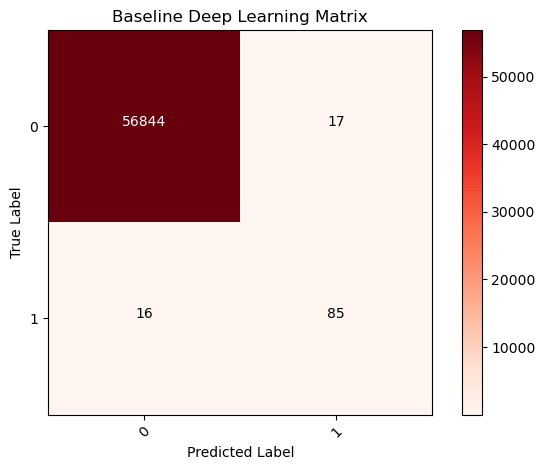

In [80]:
cnf_matrix=confusion_matrix(y_test,y_pred.round())
plot_confusion_matrix(cnf_matrix,classes=[0,1],title='Baseline Deep Learning Matrix')
plt.show()


As a first model, this is pretty good!  We have reduced our testing FALSE NEGATIVES to only 16.  Now we will apply this model to the entire dataset to see how it performs.

#### Plotting Confusion Matrix for Entire Dataset

8901/8901 [==============================] - 7s 748us/step
Confusion Matrix (Unnormalized)
[[284238     77]
 [    88    404]]


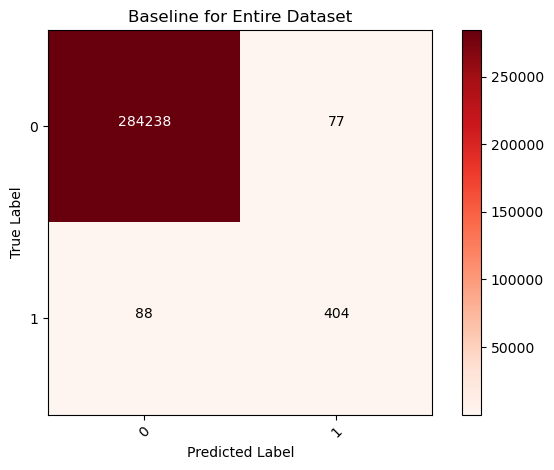

In [81]:
y_pred=model.predict(X)
y_test=pd.DataFrame(y)
cnf_matrix=confusion_matrix(y_test,y_pred.round())
plot_confusion_matrix(cnf_matrix,classes=[0,1], title='Baseline for Entire Dataset')
plt.show()

This is our baseline confusion matrix.  We are working on lowering those FALSE NEGATIVES.  Those 88 false negatives need to move over into the TRUE POSITIVE category or the FALSE POSITIVE.  Either of those would be preferable to missing fraudlent charges. 

### 3.2 Applying Random Forest Classifier <a name='applying-random-forest-classifier'><a/>

In [82]:
X=data.iloc[:,data.columns!='Class']
y=data.iloc[:,data.columns=='Class']

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

In [84]:
random_forest=RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train,y_train.values.ravel())

RandomForestClassifier()

In [85]:
y_pred=random_forest.predict(X_test)

Confusion Matrix (Unnormalized)
[[56855     6]
 [   21    80]]


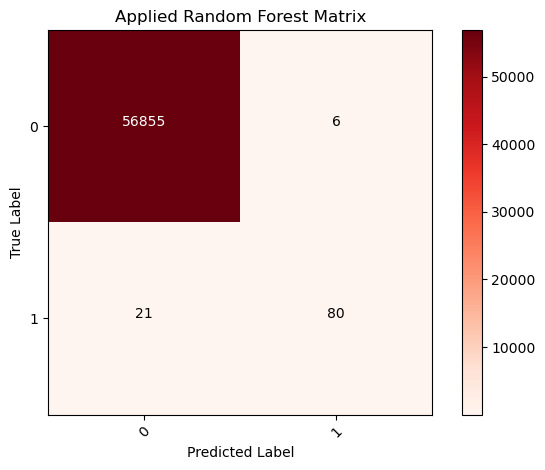

In [86]:
cnf_matrix=confusion_matrix(y_test,y_pred.round())
plot_confusion_matrix(cnf_matrix,classes=[0,1], title='Applied Random Forest Matrix')
plt.show()

There is a significant improvement in reducing down the false negatives to 21 on the test data.  Let's explore its effect on the whole dataset.

#### Confusion Matrix for Entire Dataset

Confusion Matrix (Unnormalized)
[[284309      6]
 [    21    471]]


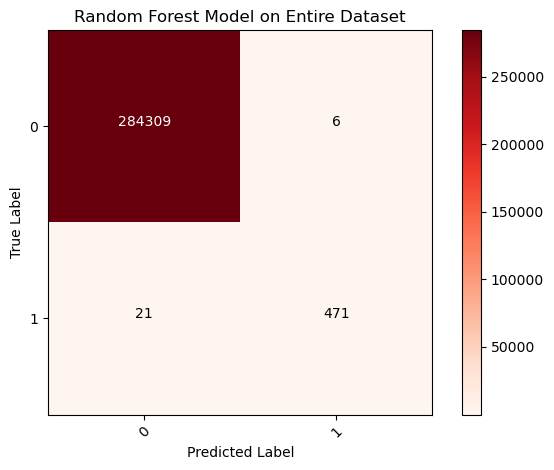

In [87]:
y_pred=random_forest.predict(X)

cnf_matrix=confusion_matrix(y,y_pred.round())
plot_confusion_matrix(cnf_matrix,classes=[0,1], title='Random Forest Model on Entire Dataset')
plt.show()

For the entire dataset the false negative reduced to 21 in comparison to deep learning model having false negatives 122 in case of entire dataset. Still there is a chance of further improvement.

### 3.3 Applying Decision Tree Classifier <a name='applying-decision-tree-classifier'><a/>

In [88]:
X=data.iloc[:,data.columns!='Class']
y=data.iloc[:,data.columns=='Class']

In [89]:


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)


In [90]:
from sklearn.tree import DecisionTreeClassifier
decc=DecisionTreeClassifier()
decc.fit(X_train,y_train.values.ravel())

DecisionTreeClassifier()

In [91]:
y_pred=decc.predict(X_test)

In [92]:
decc.score(X_test,y_test)

0.9992626663389628

Confusion Matrix (Unnormalized)
[[56839    22]
 [   20    81]]


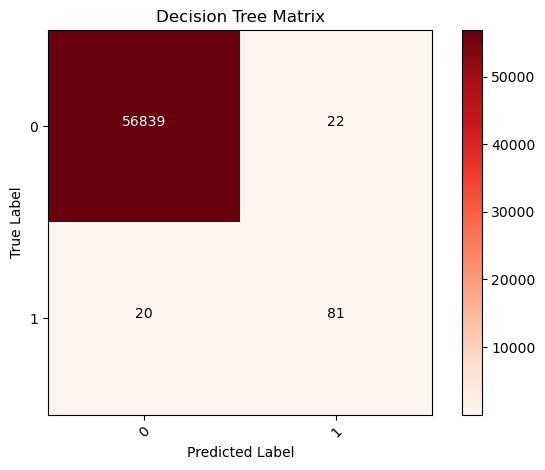

In [93]:
cnf_matrix=confusion_matrix(y_test,y_pred.round())
plot_confusion_matrix(cnf_matrix,classes=[0,1], title='Decision Tree Matrix')
plt.show()

#### Confusion Matrix for Entire Dataset

Confusion Matrix (Unnormalized)
[[284293     22]
 [    20    472]]


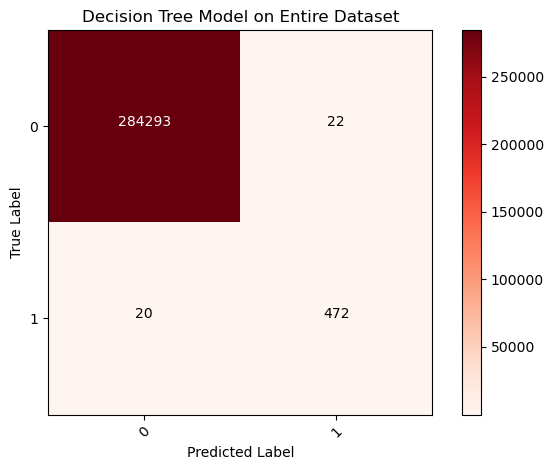

In [94]:
y_pred=decc.predict(X)

cnf_matrix=confusion_matrix(y,y_pred.round())
plot_confusion_matrix(cnf_matrix,classes=[0,1], title='Decision Tree Model on Entire Dataset')
plt.show()

### 3.4 Applying Undersampling <a name='applying-undersampling'><a/>

In [95]:
fraud_indices=np.array(data[data.Class==1].index)
no_records_fraud=len(fraud_indices)
print(no_records_fraud)

492


In [96]:
normal_indices=data[data.Class==0].index

In [97]:
random_normal_indices=np.random.choice(normal_indices,no_records_fraud,replace=False)
random_normal_indices=np.array(random_normal_indices)
print(len(random_normal_indices))

492


In [98]:
under_sample_indices=np.concatenate([fraud_indices,random_normal_indices])
print(len(under_sample_indices))

984


In [99]:
under_sample_data=data.iloc[under_sample_indices,:]

In [100]:
under_sample_data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,normalized_amount
541,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,-2.772272,...,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,1,-0.353229
623,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,-0.838587,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,1,1.761758
4920,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,-1.525412,...,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,1,0.606031
6108,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,-4.801637,...,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,1,-0.117342
6329,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,-2.447469,...,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1,-0.349231


In [101]:
X_undersample=under_sample_data.iloc[:,under_sample_data.columns!='Class']
y_undersample=under_sample_data.iloc[:,under_sample_data.columns=='Class']

In [102]:

X_train, X_test, y_train, y_test = train_test_split(X_undersample, y_undersample, test_size = 0.2, random_state=0)

In [103]:
X_train = np.array(X_train)
X_test=np.array(X_test)
y_train=np.array(y_train)
y_test=np.array(y_test)

#### Applying Keras Sequential Model on Undersampled Dataset

In [104]:
model = Sequential([
     Dense(units=16, input_dim=29, activation='relu'),
     Dense(units=24,activation='relu'),
     Dropout(0.5),
     Dense(20,activation='relu'),
     Dense(24,activation='relu'),
     Dense(1,activation='sigmoid')  
    
    
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 16)                480       
                                                                 
 dense_16 (Dense)            (None, 24)                408       
                                                                 
 dropout_3 (Dropout)         (None, 24)                0         
                                                                 
 dense_17 (Dense)            (None, 20)                500       
                                                                 
 dense_18 (Dense)            (None, 24)                504       
                                                                 
 dense_19 (Dense)            (None, 1)                 25        
                                                                 
Total params: 1,917
Trainable params: 1,917
Non-traina

In [105]:
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
model.fit(X_train,y_train, batch_size=15, epochs=5)

Epoch 1/5
53/53 [==============================] - 0s 1ms/step - loss: 0.5584 - accuracy: 0.5769
Epoch 2/5
53/53 [==============================] - 0s 1ms/step - loss: 0.4296 - accuracy: 0.8285
Epoch 3/5
53/53 [==============================] - 0s 1ms/step - loss: 0.3508 - accuracy: 0.8856
Epoch 4/5
53/53 [==============================] - 0s 1ms/step - loss: 0.2609 - accuracy: 0.9225
Epoch 5/5
53/53 [==============================] - 0s 1ms/step - loss: 0.2317 - accuracy: 0.9187


7/7 [==============================] - 0s 1ms/step
Confusion Matrix (Unnormalized)
[[99  7]
 [ 6 85]]


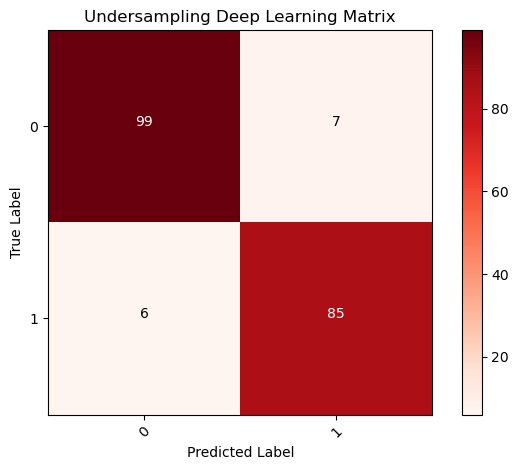

In [106]:
y_pred=model.predict(X_test)
y_expected=pd.DataFrame(y_test)

cnf_matrix=confusion_matrix(y_expected,y_pred.round())
plot_confusion_matrix(cnf_matrix,classes=[0,1], title='Undersampling Deep Learning Matrix')
plt.show()

#### Confusion Matrix for Entire Dataset

8901/8901 [==============================] - 7s 753us/step
Confusion Matrix (Unnormalized)
[[275241   9074]
 [    43    449]]


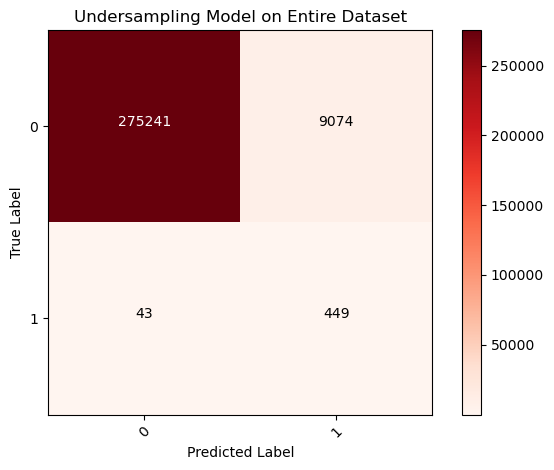

In [107]:
y_pred=model.predict(X)

cnf_matrix=confusion_matrix(y,y_pred.round())
plot_confusion_matrix(cnf_matrix,classes=[0,1], title='Undersampling Model on Entire Dataset')
plt.show()

### Applying SMOTE for Oversampling <a name='applying-SMOTE-for-oversampling'><a/>

SMOTE (Synthetic Minority Over-sampling Technique) is a method used to address class imbalance in machine learning datasets, particularly in binary classification problems. Unlike undersampling, which reduces the number of instances in the majority class, SMOTE oversampling aims to increase the number of instances in the minority class by generating synthetic samples.

The main idea behind SMOTE is to create synthetic examples of the minority class by interpolating between existing minority class instances. This is achieved by selecting a minority class instance and finding its k nearest neighbors in feature space. A new instance is then created by randomly selecting one of these neighbors and generating a synthetic example along the line segment joining the two instances. 

Here is an image showing an example of what SMOTE might look like:


<img src="https://miro.medium.com/v2/resize:fit:720/format:webp/1*CeOd_Wbn7O6kpjSTKTIUog.png" alt="drawing" />

This is useful for our model, as we have a very large class imbalance that SMOTE can help correct.  We will apply SMOTE and then apply the same Keras process that we did earlier.

In [108]:
X_resample,y_resample=SMOTE().fit_resample(X,y.values.ravel())

In [109]:
y_resample=pd.DataFrame(y_resample)
X_resample=pd.DataFrame(X_resample)

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X_resample, y_resample, test_size = 0.2, random_state=0)

In [111]:
X_train = np.array(X_train)
X_test=np.array(X_test)
y_train=np.array(y_train)
y_test=np.array(y_test)

#### Applying Keras Sequential Model on Oversampled Dataset

In [112]:
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
model.fit(X_train,y_train, batch_size=15, epochs=5)

Epoch 1/5
30327/30327 [==============================] - 36s 1ms/step - loss: 0.0422 - accuracy: 0.9850
Epoch 2/5
30327/30327 [==============================] - 36s 1ms/step - loss: 0.0177 - accuracy: 0.9949
Epoch 3/5
30327/30327 [==============================] - 36s 1ms/step - loss: 0.0138 - accuracy: 0.9962
Epoch 4/5
30327/30327 [==============================] - 36s 1ms/step - loss: 0.0118 - accuracy: 0.9970
Epoch 5/5
30327/30327 [==============================] - 36s 1ms/step - loss: 0.0107 - accuracy: 0.9972


3554/3554 [==============================] - 3s 764us/step
Confusion Matrix (Unnormalized)
[[56551   173]
 [    0 57002]]


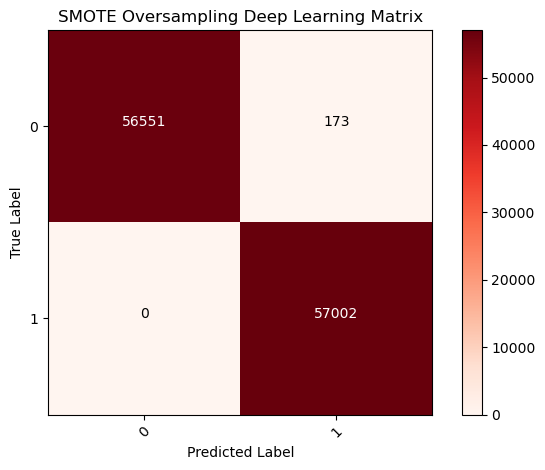

In [113]:
y_pred=model.predict(X_test)
y_expected=pd.DataFrame(y_test)

cnf_matrix=confusion_matrix(y_expected,y_pred.round())
plot_confusion_matrix(cnf_matrix,classes=[0,1], title='SMOTE Oversampling Deep Learning Matrix')
plt.show()

#### Confusion Matrix for Entire Dataset

8901/8901 [==============================] - 7s 767us/step
Confusion Matrix (Unnormalized)
[[283532    783]
 [     0    492]]


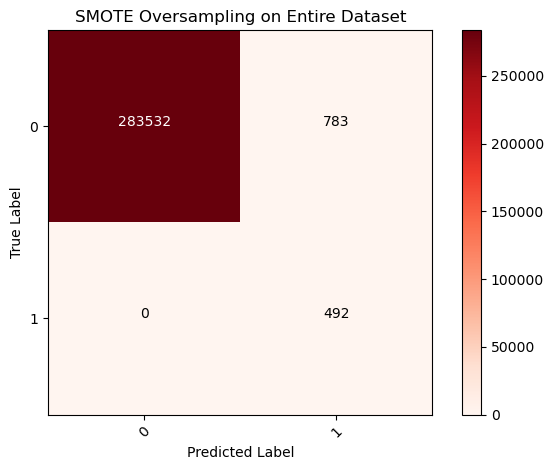

In [114]:
y_pred=model.predict(X)

cnf_matrix=confusion_matrix(y,y_pred.round())
plot_confusion_matrix(cnf_matrix,classes=[0,1], title='SMOTE Oversampling on Entire Dataset')
plt.show()

# Conclusion <a name='conclusion'><a/>
Since, our goal was to reduce the false negatives which we have successfully reduced to 0 using SMOTE oversampling technique. There might be some concern about the fact that there is a large amount of False Positives, but I posit that this is not a problem for our data.  First, the number is statistically insignificant.  Second, a False Positive is not a large problem.  The downside of a false positive can be mitigated by customer service and further examination of the issue, where as a False Negative is a costly problem for the company, affecting the bottom-line and public image.  It also detrimentally affects the customer.

### Further Improvements



Further improvements that could be done would be to increase the epochs and batch size.  Increasing the number of epochs and batch size could improve model performance and generalization.  The reason I didn't was due to longer training times and lack of machine resources. However, increased epoch and batch sizes can lead to an increased risk of overfitting. 